In [40]:
import pandas as pd
import numpy as np
import math
from scipy.stats import weibull_min, invweibull, uniform, norm, multivariate_normal
from scipy.interpolate import interp1d
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from pylab import rcParams

import seaborn as sns

import helpers

sns.set()

rcParams['figure.figsize'] = 20,20

# Create the P function from matlab
data = np.loadtxt("powermat.csv", delimiter=",")
x = np.arange(0,30,0.001)
P = interp1d(x,data, fill_value="extrapolate")

# Creating lambda function allowing faster calculations
calculate_power = lambda x: P(x)
#_ = plt.plot(x,P(x))

n = 10**5

hlp = helpers.helper_methods(n)
hlp.init_winds()

# 2 a)

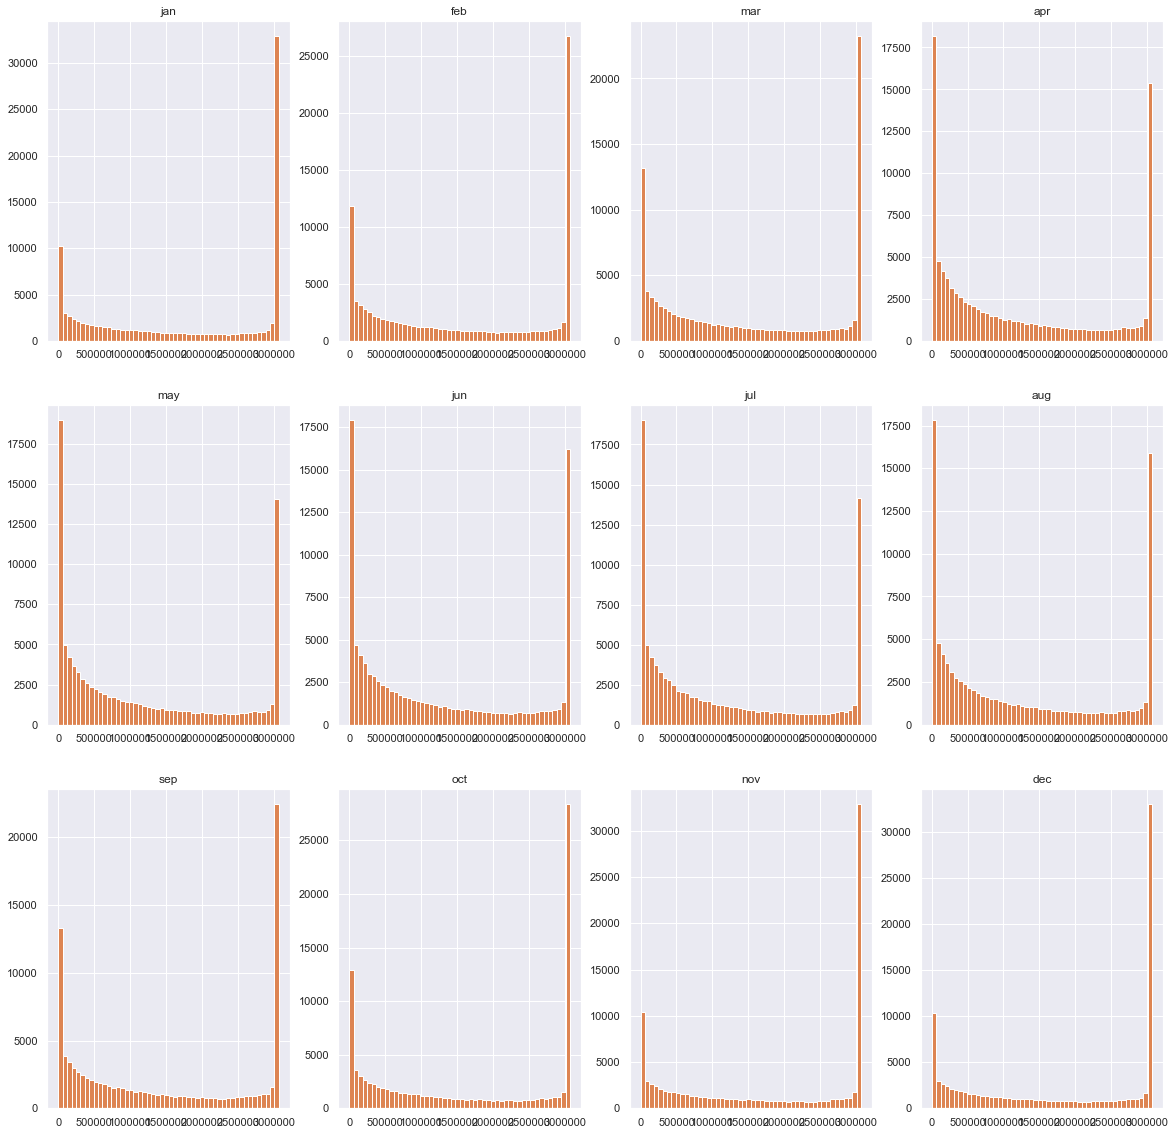

In [41]:
# A) Expected amount of power
i = 1
result = []

for key, wind in hlp.winds.items():

    # Plotting
    plt.subplot(3,4,i)
    i+=1
    plt.hist(wind["wind"], bins=100, density=True)
    plt.gca().set_title(key)

    # Calculated power from the generated wind
    power = P(wind["wind"])
    hist = plt.hist(power, bins=50)

    # Calculating mean, variance and the confidence interval for the mean
    mean = np.mean(power)
    var = np.var(power)
    confidence_interval = 1.96*np.sqrt(var/n)
    
    result.append({"Month" : key, "$\tau$ [kW]": f'{np.round(mean, decimals = 2)}',
                   "$I_{95\%}$": f' $\pm$ {np.round(confidence_interval, decimals=2)}',
                    "$\mathbb{V}(\tau)$ ": np.round(var, decimals=2)})
    
with open('crudeMC.tex','w') as table:
     table.write(pd.DataFrame(result).set_index(keys="Month").to_latex(escape = False))

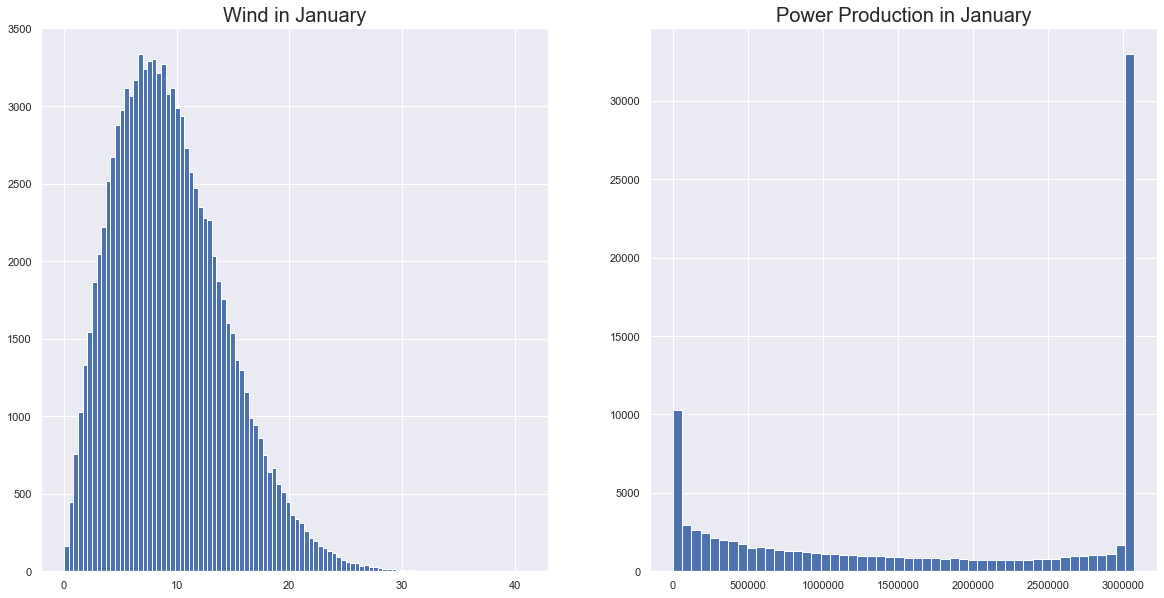

In [55]:
fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.hist(wind["wind"], bins=100)
plt.gca().set_title('Wind in January', fontsize = 20)


plt.subplot(1,2,2)
power = P(wind["wind"])
hist = plt.hist(power, bins=50)
plt.gca().set_title('Power Production in January', fontsize = 20)
plt.show()
fig.savefig('janCrude.png')

# 2 a) Truncated U

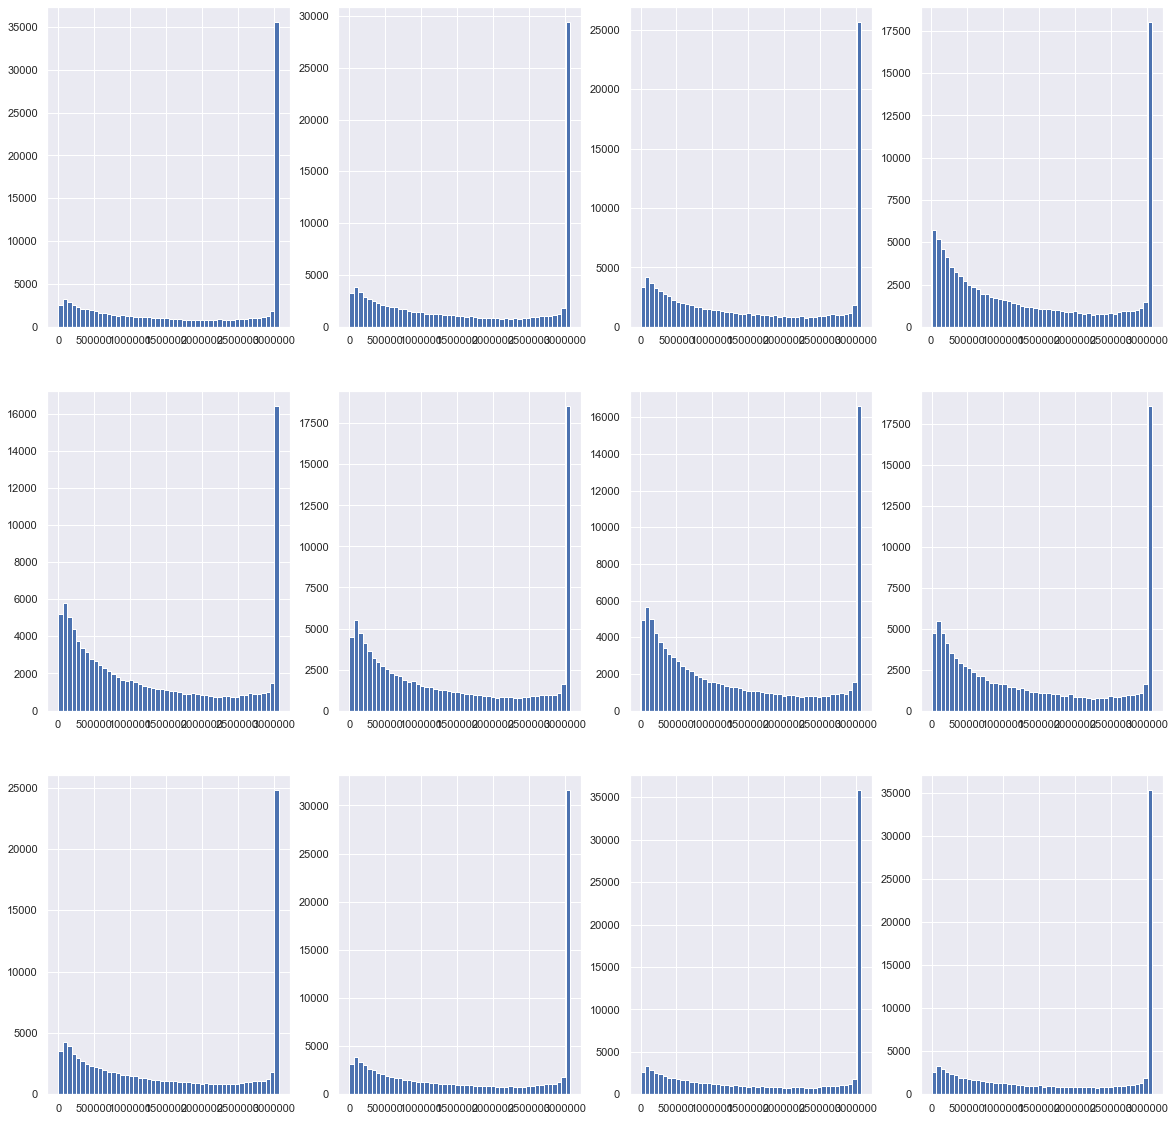

In [42]:
# A) Expected amount of power, truncated version
i = 1

result = []

for key, wind in hlp.winds.items():

    # Calculating F(3) and F(25) for the distribution for the wind
    F_min = wind["dist"].cdf(3)
    F_max = wind["dist"].cdf(25)

    # Generate uniform data
    u = uniform.rvs(size=n)

    # Fix condition to U
    u = ((F_max-F_min)*u + F_min)

    # Run u through inverse of weibull 
    wind_truncated = wind["dist"].ppf(u)

    # Calculated the power for the truncated wind
    power_trunc = calculate_power(wind_truncated)

    plt.subplot(3,4,i)
    i+=1
    hist = plt.hist(power_trunc, bins=50)

    # Calculating mean, variance and the confidence interval for the mean
    mean = np.mean(power_trunc)*(F_max-F_min)
    var = np.var(power_trunc)*((F_max-F_min)**2)
    confidence_interval = 1.96*np.sqrt(var/n)

    result.append({"Month" : key, "$\tau$ [kW]": f'{np.round(mean, decimals = 2)}',
                   "$I_{95\%}$": f' $\pm$ {np.round(confidence_interval, decimals=2)}',
                    "$\mathbb{V}(\tau)$": np.round(var, decimals=2)})
    
with open('crudeMCtrunc.tex','w') as table:
     table.write(pd.DataFrame(result).set_index(keys="Month").to_latex(escape = False))

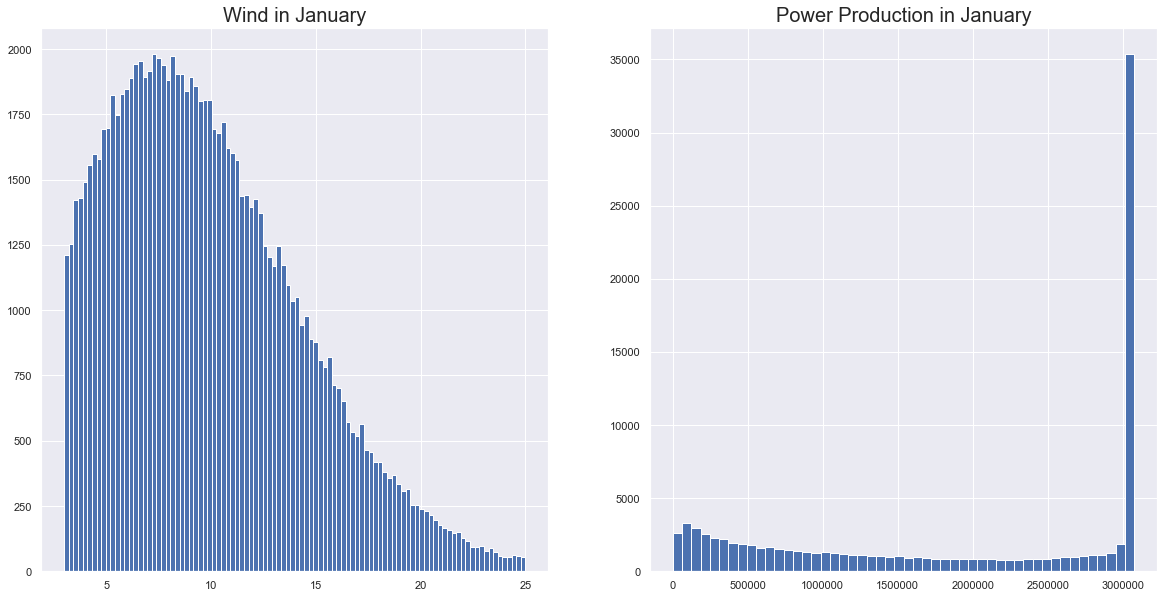

In [57]:
fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.hist(wind_truncated, bins=100)
plt.gca().set_title('Wind in January', fontsize = 20)


plt.subplot(1,2,2)
power = P(wind["wind"])
hist = plt.hist(power_trunc, bins=50)
plt.gca().set_title('Power Production in January', fontsize = 20)
plt.show()
fig.savefig('janCrudeTrunc.png')

# 2 b) Importance Sampling

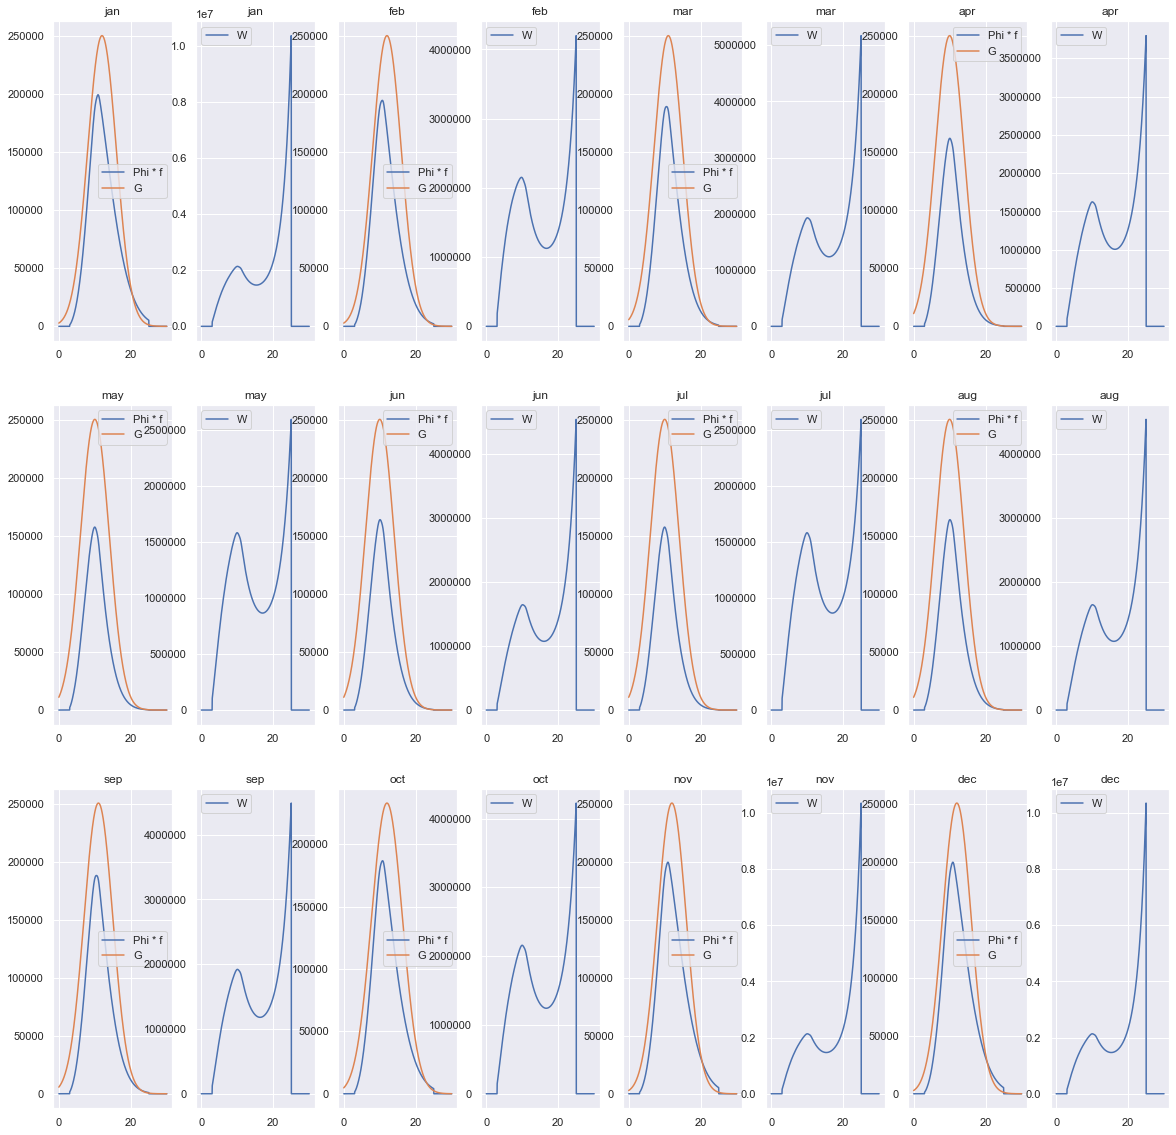

In [43]:
x = np.linspace(0,30, num=n)
i = 1
result = []

g_parameters  = {
        "jan" : [12, 4],
        "feb" : [12, 4],
        "mar" : [11, 4],
        "apr" : [10, 4],
        "may" : [10, 4],
        "jun" : [10, 4],
        "jul" : [10, 4],
        "aug" : [10, 4],
        "sep" : [11, 4],
        "oct" : [12, 4.3],
        "nov" : [12, 4],
        "dec" : [12, 4]
    }

for key, wind in hlp.winds.items():

    h = lambda x: P(x)*wind["dist"].pdf(x)

    # Selecting g as a normal distribution
    my = g_parameters[key][0]
    sigma2 = g_parameters[key][1]
    g_scale = 10**6.4
    g_dist = norm(my, sigma2)
    g = lambda x: g_dist.pdf(x)
    
    plt.subplot(3,8,i)
    
    i+=1
    plt.plot(x, h(x), label="Phi * f")
    plt.plot(x, g(x)*g_scale, label="G")
    plt.legend()
    plt.gca().set_title(key)

    plt.subplot(3,8,i)
    i+=1
    plt.plot(x, h(x)/g(x), label="W")
    plt.gca().set_title(key)
    plt.legend()

    X = g_dist.rvs(size=n)

    # Function to evaluate
    s = lambda x: h(x)/g(x)

    # Calculate variance
    mean = np.mean(s(X))
    var = np.var(s(X))
    confidence_interval = 1.96*np.sqrt(var/n)
    
    result.append({"Month" : key, "$\tau$ [kW]": f'{np.round(mean, decimals = 2)}',
                   "$I_{95\%}$": f' $\pm$ {np.round(confidence_interval, decimals=2)}',
                    "$\mathbb{V}(\tau)$": np.round(var, decimals=2)})

with open('ISMC.tex','w') as table:
     table.write(pd.DataFrame(result).set_index(keys="Month").to_latex(escape = False))

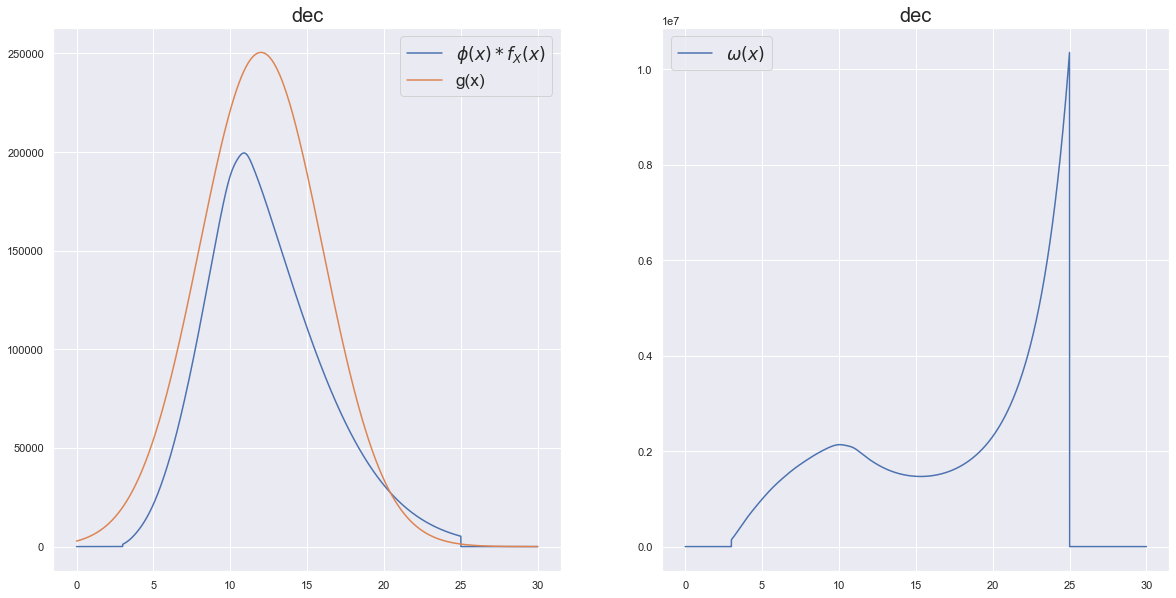

In [65]:
h = lambda x: P(x)*wind["dist"].pdf(x)
my = g_parameters[key][0]
sigma2 = g_parameters[key][1]
g_scale = 10**6.4
g_dist = norm(my, sigma2)
g = lambda x: g_dist.pdf(x)

fig = plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.plot(x, h(x), label="$\phi(x) * f_X(x)$")
plt.plot(x, g(x)*g_scale, label="g(x)")
plt.legend(fontsize = 'x-large')
plt.gca().set_title(key, fontsize = 20)

plt.subplot(1,2,2)
plt.plot(x, h(x)/g(x), label="$\omega(x)$")
plt.gca().set_title(key, fontsize = 20)
plt.legend(fontsize = 'x-large')

plt.show()
fig.savefig('janISMC.png')

# 2 c) Antithetic sampling

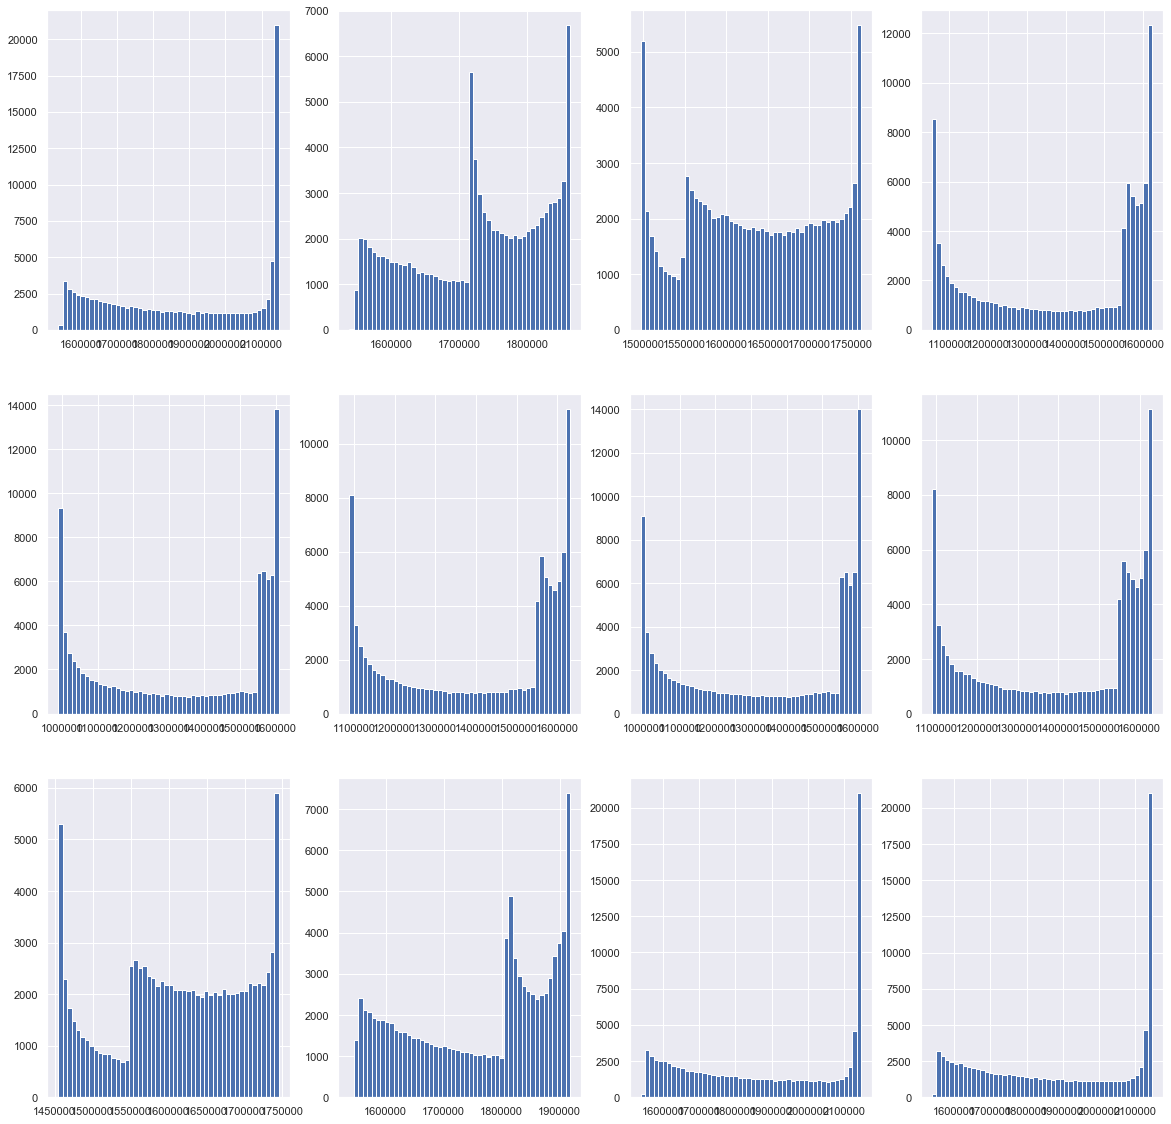

In [66]:
# A) Expected amount of power, truncated version
i = 1
result = []

for key, wind in hlp.winds.items():

    # Calculating F(3) and F(25) for the distribution for the wind
    F_min = wind["dist"].cdf(3)
    F_max = wind["dist"].cdf(25)

    # Generate uniform data
    u = uniform.rvs(size=n)
    u2 = 1 - u

    # Fix condition to U
    u = ((F_max-F_min)*u + F_min)
    u2 = ((F_max-F_min)*u2 + F_min)

    # Run u through inverse of weibull
    v = P(wind["dist"].ppf(u))
    v2 = P(wind["dist"].ppf(u2))
    
    # Calculated the power for the truncated wind
    w = (v + v2)/2

    plt.subplot(3,4,i)
    i+=1
    hist = plt.hist(w, bins=50)

    # Calculating mean, variance and the confidence interval for the mean
    mean = np.mean(w)*(F_max-F_min)
    var = np.var(w)*((F_max-F_min)**2)
    confidence_interval = 1.96*np.sqrt(var/n)

    result.append({"Month" : key, "$\tau$ [kW]": f'{np.round(mean, decimals = 2)}',
                   "$I_{95\%}$": f'$\pm$ {np.round(confidence_interval, decimals=2)}',
                    "$\mathbb{V}(\tau)$": np.round(var, decimals=2)})
    
with open('ATSMC.tex','w') as table:
     table.write(pd.DataFrame(result).set_index(keys="Month").to_latex(escape = False))

# 2 d)

In [45]:
# Probability that the turbine delivers power
result = []
for key, wind in hlp.winds.items():
    # Calculating F(3) and F(25) for the distribution for the wind
    F_min = wind["dist"].cdf(3)
    F_max = wind["dist"].cdf(25)
    result.append({"Month" : key, "$\mathbb{P}(P > 0)$": f'{(F_max - F_min)*100}$\%$'})

with open('powerProb.tex','w') as table:
     table.write(pd.DataFrame(result).set_index(keys="Month").to_latex(escape = False))

# 2 e) Estimating power ratio

<ipython-input-83-424c9a1a31b1>:25: RuntimeWarning:

invalid value encountered in true_divide

<ipython-input-83-424c9a1a31b1>:45: RuntimeWarning:

invalid value encountered in true_divide



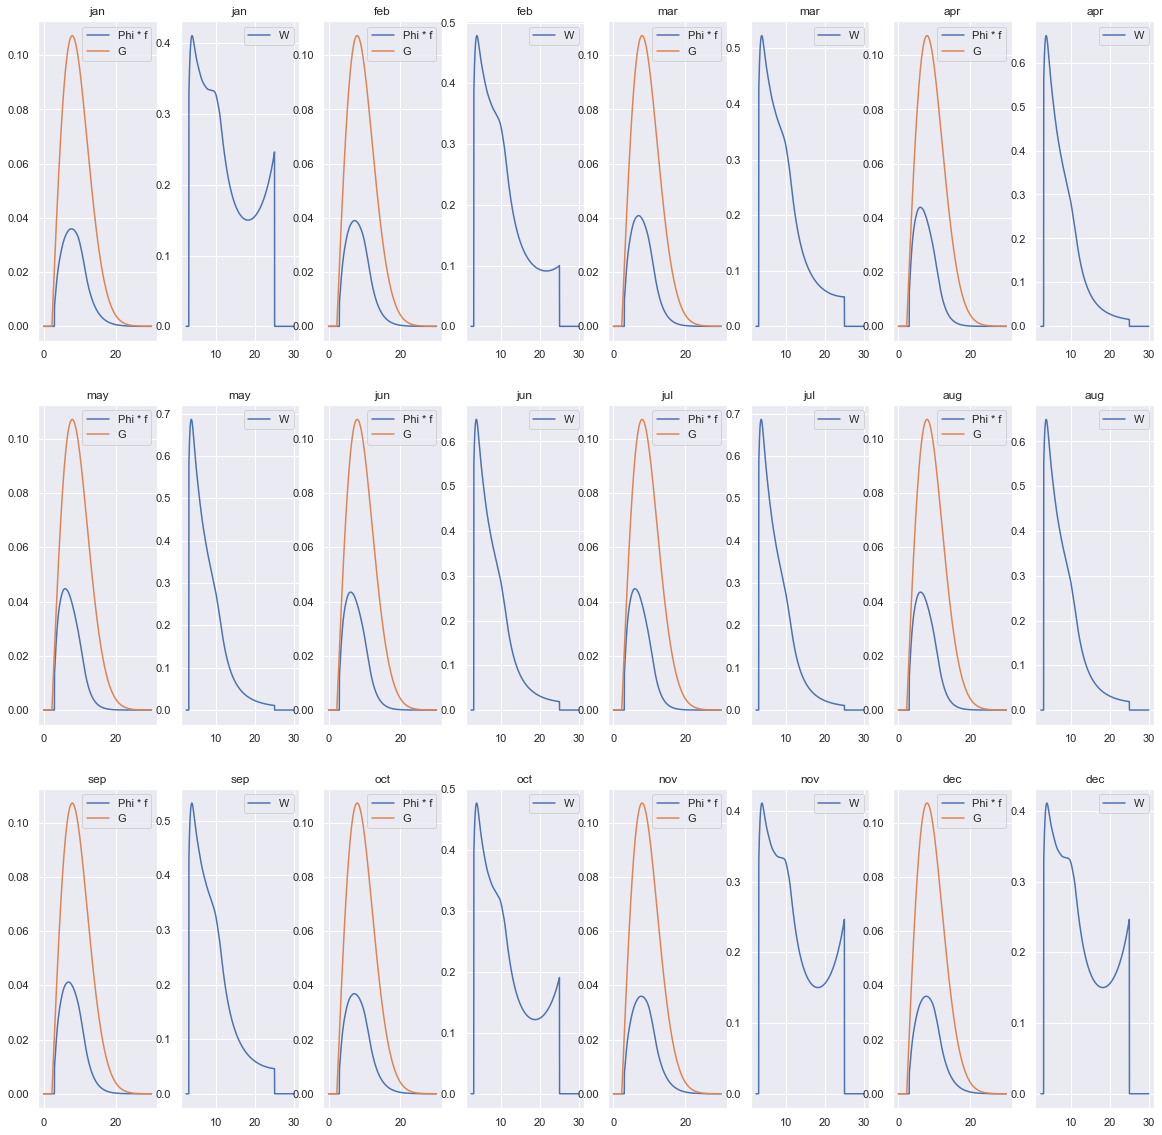

In [83]:
Ptot = lambda v: 1/2*1.225*math.pi*112**2/4*v**3
x = np.linspace(0,30, num=n)

i = 1

result = []

g_parameters  = {
        "jan" : [8, 2, 2.3],
        "feb" : [8, 2, 2.3],
        "mar" : [8, 2, 2.3],
        "apr" : [8, 2, 2.3],
        "may" : [8, 2, 2.3],
        "jun" : [8, 2, 2.3],
        "jul" : [8, 2, 2.3],
        "aug" : [8, 2, 2.3],
        "sep" : [8, 2, 2.3],
        "oct" : [8, 2, 2.3],
        "nov" : [8, 2, 2.3],
        "dec" : [8, 2, 2.3],
    }

for key, wind in hlp.winds.items():
        
    h = lambda x: P(x)/Ptot(x)*wind["dist"].pdf(x)

    # Selecting g as a weibull distribution
    g_dist_lambda = g_parameters[key][0] 
    g_dist_k = g_parameters[key][1] 
    loc = g_parameters[key][2] 
    
    g_dist = weibull_min(g_dist_k, loc = loc, scale = g_dist_lambda)
    g = lambda x: g_dist.pdf(x)

    plt.subplot(3,8,i)
    
    i+=1
    plt.plot(x, h(x), label="Phi * f")
    plt.plot(x, g(x), label="G")
    plt.legend()
    plt.gca().set_title(key)

    plt.subplot(3,8,i)
    i+=1
    plt.plot(x, h(x)/g(x), label="W")
    plt.gca().set_title(key)
    plt.legend()


    X = g_dist.rvs(size=n)

    # Function to evaluate
    s = lambda x: h(x)/g(x)
    sample = s(X)
    
    # Calculate variance
    mean = np.mean(sample)
    var = np.var(sample)
    confidence_interval = 1.96*np.sqrt(var/n)
                   
    result.append({"Month" : key, "$\tau$ [$\eta$]": f'{(np.round(mean*100, decimals = 2))} $\%$',
                   "$I_{95\%}$": f'$\pm$ {(np.round(confidence_interval*100, decimals= 2))} $\%$',
                    "$\mathbb{V}(\tau)$": np.round(var, decimals=2)})
    
with open('powerRatio.tex','w') as table:
     table.write(pd.DataFrame(result).set_index(keys="Month").to_latex(escape = False))

# Uppgift 3

In [ ]:
# Selecting the appropiate disitribvtions
# Uppgift 3
# A
k = 1.96
lamda = 9.13

# Creating the marginal wind distribution
wind_distribution =  weibull_min(k,loc=0, scale=lamda)

# Constants
a = 0.638
p = 3
q = 1.5

# Multivariate densyty function
f = lambda v1, v2: wind_distribution.pdf(v1)*wind_distribution.pdf(v2)*(1+a*(1-wind_distribution.cdf(v1)**p)**(q-1)
                          *(1-wind_distribution.cdf(v2)**p)**(q-1)
                          *(wind_distribution.cdf(v1)**p*(1+p*q)-1)
                          *(wind_distribution.cdf(v2)**p*(1+p*q)-1))


# Selecting g as a multivariate normal distribution
mean = [12, 12] 
matrix = [[6, 1], [1, 6]] 
g_dist_multi = multivariate_normal(mean, matrix)
g_dist_normal = norm(mean[0], matrix[0][0])

x = np.linspace(0,30,60)
y = np.linspace(0,30,60)

x, y = np.meshgrid(x, y)
pos = np.dstack((x, y))

scale_constant = 5*10**12

fig = go.Figure(data=[go.Surface(z=f(x,y)*P(x)*P(y), x=x, y=y), 
                      go.Surface(z=scale_constant*g_dist_multi.pdf(pos), x=x, y=y, colorscale='Blues', opacity=0.5)])

fig.update_layout(title='Mt Bruno Elevation', autosize=True,
                  width=800, height=500)

fig.show()

In [ ]:
# Drag n samples
bivariate_samples = g_dist_multi.rvs(n)

# Creating two seperate winds
v1 = P(wind_distribution.rvs(n))
v2 = P(wind_distribution.rvs(n))

# Generate P(V1) and P(V2)
G1 = bivariate_samples.transpose()[0]
G2 = bivariate_samples.transpose()[1]

# Vectorizing for speed
samples_cov = P(G1)*P(G2)*f(G1,G2)/g_dist_multi.pdf(bivariate_samples)

sample_sum = (P(G1)+P(G2))*f(G1,G2)/g_dist_multi.pdf(bivariate_samples)

# Mean in task A)
mean = np.mean(v1)+np.mean(v2)

# Calculate covariance task B)
cov = np.mean(samples_cov) - np.mean(v1)*np.mean(v2)

# Calculate variance in task C)
var = np.var(v1)+np.var(v2)+2*cov

# Calculate std in task C)
std = np.sqrt(var)

print(f'MEAN: {np.format_float_scientific(mean, precision=2)}')
print(f'COV: {np.format_float_scientific(cov, precision=2)}')
print(f'VAR: {np.format_float_scientific(var, precision=2)}')
print(f'STD: {np.format_float_scientific(std, precision=2)}')

# D

nr_over_3075 = len(list(filter(lambda x: x > 3.075*10**6, sample_sum)))
nr_below_3075 = len(list(filter(lambda x: x < 3.075*10**6, sample_sum)))
exact_values = len(list(filter(lambda x: x == 3.075*10**6, sample_sum)))
percentage_over = nr_over_3075/n
percentage_below = nr_below_3075/n

print(f'Percentage over: {percentage_over*100} %')
print(f'Percentage over: {percentage_below*100} %')
print(f'Sum of percentage: {percentage_below + percent_over}')